# Our goal is to predict the Churn out of a bank.

This project is being developed by:
- Jorge Rodrigo Velázquez
- Leandro Sartini de Campos
- Mohamed Maaz Rehan
- Aman Nain
- Prakash Pun
- Saraka Sahaswin
- Bibek Ranjit

## Dataset Description

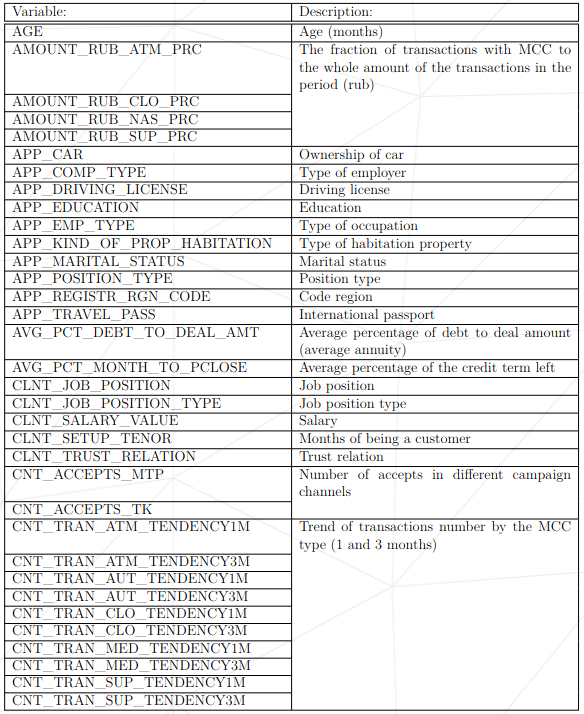

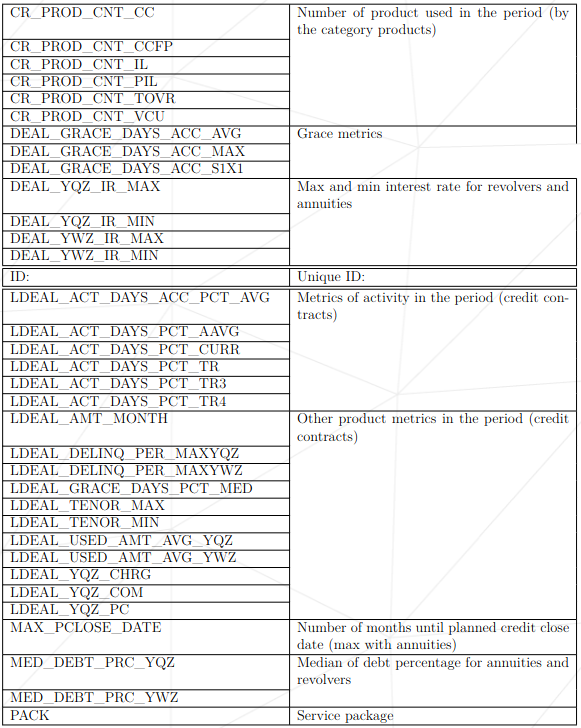

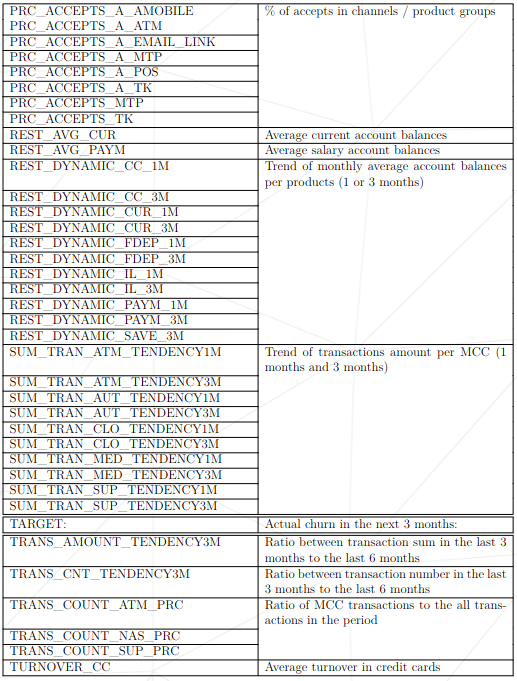

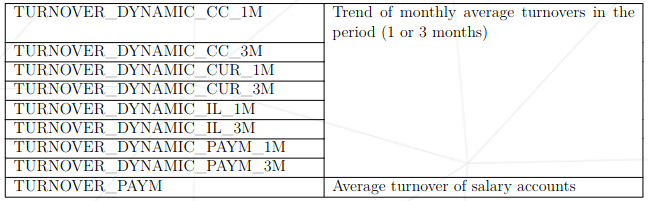

MECE Table

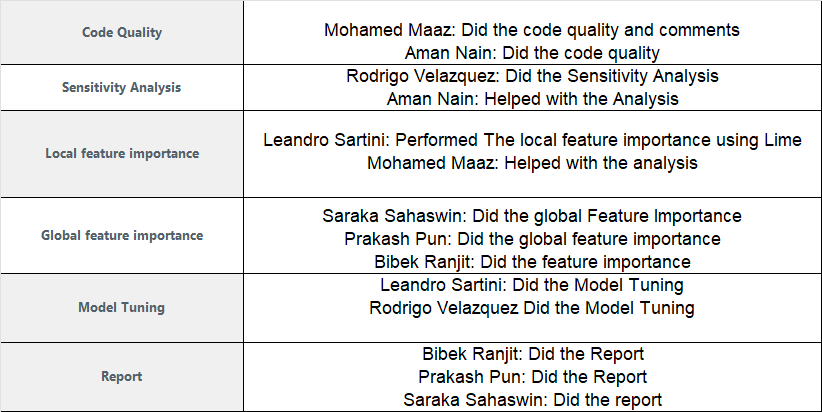

### Step by step of what we are going to do

## Importing all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,roc_auc_score,f1_score,roc_curve,auc
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import NearMiss
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap
import warnings
from SALib import ProblemSpec
import pickle
warnings.filterwarnings('ignore')

## Importing the file

In [3]:
df = pd.read_csv('../data/processed/first_preprocessed_df.csv')

In [7]:
df['PACK'].unique()

array(['K01', '102', '105', 'O01', '103', '101', '107', '301', '104',
       '108', '109', 'M01'], dtype=object)

In [ ]:
df['AGE']=df['AGE']/12

### train test split

In [ ]:
X_col = list(df.columns)

In [ ]:
X_col.remove('TARGET')

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df[X_col],df['TARGET'],test_size= 0.25,random_state=42)

Let's start with the ones that are concentrated

In [ ]:
def get_mode(series):
    if not series.mode().empty:
        s = series.mode().iloc[0]  
        return s
    else:
        return None

In [ ]:
imputation_dict = {
 'AMOUNT_RUB_CLO_PRC' :  X_train.groupby('PACK')['AMOUNT_RUB_CLO_PRC'].apply(get_mode).to_dict(),
 'AMOUNT_RUB_NAS_PRC' :  X_train.groupby('PACK')['AMOUNT_RUB_NAS_PRC'].apply(get_mode).to_dict(),
 'TRANS_COUNT_NAS_PRC' : X_train.groupby('PACK')['TRANS_COUNT_NAS_PRC'].apply(get_mode).to_dict()
}

In [ ]:
pack_list = list(df['PACK'].unique())
pack_list.remove('108')
pack_list.remove('M01')
for item in df['PACK'].unique():
    X_train.loc[X_train['PACK']== item,'AMOUNT_RUB_CLO_PRC'] = imputation_dict['AMOUNT_RUB_CLO_PRC'][item]
    X_train.loc[X_train['PACK']== item,'AMOUNT_RUB_NAS_PRC'] = imputation_dict['AMOUNT_RUB_NAS_PRC'][item]
    X_train.loc[X_train['PACK']== item,'TRANS_COUNT_NAS_PRC'] = imputation_dict['TRANS_COUNT_NAS_PRC'][item]
    X_test.loc[X_test['PACK']== item,'AMOUNT_RUB_CLO_PRC'] = imputation_dict['AMOUNT_RUB_CLO_PRC'][item]
    X_test.loc[X_test['PACK']== item,'AMOUNT_RUB_NAS_PRC'] = imputation_dict['AMOUNT_RUB_NAS_PRC'][item]
    X_test.loc[X_test['PACK']== item,'TRANS_COUNT_NAS_PRC'] = imputation_dict['TRANS_COUNT_NAS_PRC'][item]

amount_clo = X_train['AMOUNT_RUB_CLO_PRC'].mode()[0]
amount_nas = X_train['AMOUNT_RUB_NAS_PRC'].mode()[0]
trans_nas = X_train['TRANS_COUNT_NAS_PRC'].mode()[0]
    
X_train['AMOUNT_RUB_CLO_PRC'].fillna(amount_clo,inplace = True)
X_train['AMOUNT_RUB_NAS_PRC'].fillna(amount_nas,inplace = True)
X_train['TRANS_COUNT_NAS_PRC'].fillna(trans_nas,inplace = True)
X_test['AMOUNT_RUB_CLO_PRC'].fillna(amount_clo,inplace = True)
X_test['AMOUNT_RUB_NAS_PRC'].fillna(amount_nas,inplace = True)
X_test['TRANS_COUNT_NAS_PRC'].fillna(trans_nas,inplace = True)

In [ ]:
check = ['AMOUNT_RUB_CLO_PRC','AMOUNT_RUB_NAS_PRC','TRANS_COUNT_NAS_PRC']

In [ ]:
X_train[check].isnull().sum()

Let's go to the Skewed ones now

In [ ]:
imputation_dict.update({
 'AMOUNT_RUB_SUP_PRC' :  X_train.groupby('PACK')['AMOUNT_RUB_SUP_PRC'].median().to_dict(),
 'TRANS_COUNT_SUP_PRC' :  X_train.groupby('PACK')['TRANS_COUNT_SUP_PRC'].median().to_dict(),
 'TRANS_COUNT_ATM_PRC' : X_train.groupby('PACK')['TRANS_COUNT_ATM_PRC'].median().to_dict(),
 'AMOUNT_RUB_ATM_PRC' :  X_train.groupby('PACK')['AMOUNT_RUB_ATM_PRC'].median().to_dict(),
 'CNT_TRAN_ATM_TENDENCY1M' :  X_train.groupby('PACK')['CNT_TRAN_ATM_TENDENCY1M'].median().to_dict(),
 'SUM_TRAN_ATM_TENDENCY1M' :  X_train.groupby('PACK')['SUM_TRAN_ATM_TENDENCY1M'].median().to_dict()
})

In [ ]:
pack_list = list(df['PACK'].unique())
pack_list.remove('108')
pack_list.remove('M01')
for item in df['PACK'].unique():
    X_train.loc[X_train['PACK']== item,'AMOUNT_RUB_SUP_PRC'] = imputation_dict['AMOUNT_RUB_SUP_PRC'][item]
    X_train.loc[X_train['PACK']== item,'TRANS_COUNT_SUP_PRC'] = imputation_dict['TRANS_COUNT_SUP_PRC'][item]
    X_train.loc[X_train['PACK']== item,'TRANS_COUNT_ATM_PRC'] = imputation_dict['TRANS_COUNT_ATM_PRC'][item]
    X_train.loc[X_train['PACK']== item,'AMOUNT_RUB_ATM_PRC'] = imputation_dict['AMOUNT_RUB_ATM_PRC'][item]
    X_train.loc[X_train['PACK']== item,'CNT_TRAN_ATM_TENDENCY1M'] = imputation_dict['CNT_TRAN_ATM_TENDENCY1M'][item]
    X_train.loc[X_train['PACK']== item,'SUM_TRAN_ATM_TENDENCY1M'] = imputation_dict['SUM_TRAN_ATM_TENDENCY1M'][item]
    X_test.loc[X_test['PACK']== item,'AMOUNT_RUB_SUP_PRC'] = imputation_dict['AMOUNT_RUB_SUP_PRC'][item]
    X_test.loc[X_test['PACK']== item,'TRANS_COUNT_SUP_PRC'] = imputation_dict['TRANS_COUNT_SUP_PRC'][item]
    X_test.loc[X_test['PACK']== item,'TRANS_COUNT_ATM_PRC'] = imputation_dict['TRANS_COUNT_ATM_PRC'][item]
    X_test.loc[X_test['PACK']== item,'AMOUNT_RUB_ATM_PRC'] = imputation_dict['AMOUNT_RUB_ATM_PRC'][item]
    X_test.loc[X_test['PACK']== item,'CNT_TRAN_ATM_TENDENCY1M'] = imputation_dict['CNT_TRAN_ATM_TENDENCY1M'][item]
    X_test.loc[X_test['PACK']== item,'SUM_TRAN_ATM_TENDENCY1M'] = imputation_dict['SUM_TRAN_ATM_TENDENCY1M'][item]

median_1 = X_train['AMOUNT_RUB_SUP_PRC'].median()
median_2 = X_train['TRANS_COUNT_SUP_PRC'].median()
median_3 = X_train['TRANS_COUNT_ATM_PRC'].median()
median_4 = X_train['AMOUNT_RUB_ATM_PRC'].median()
median_5 = X_train['CNT_TRAN_ATM_TENDENCY1M'].median()
median_6 = X_train['SUM_TRAN_ATM_TENDENCY1M'].median()
    
X_train['AMOUNT_RUB_SUP_PRC'].fillna(median_1,inplace = True)
X_train['TRANS_COUNT_SUP_PRC'].fillna(median_2,inplace = True)
X_train['TRANS_COUNT_ATM_PRC'].fillna(median_3,inplace = True)
X_train['AMOUNT_RUB_ATM_PRC'].fillna(median_4,inplace = True)
X_train['CNT_TRAN_ATM_TENDENCY1M'].fillna(median_5,inplace = True)
X_train['SUM_TRAN_ATM_TENDENCY1M'].fillna(median_6,inplace = True)
X_test['AMOUNT_RUB_SUP_PRC'].fillna(median_1,inplace = True)
X_test['TRANS_COUNT_SUP_PRC'].fillna(median_2,inplace = True)
X_test['TRANS_COUNT_ATM_PRC'].fillna(median_3,inplace = True)
X_test['AMOUNT_RUB_ATM_PRC'].fillna(median_4,inplace = True)
X_test['CNT_TRAN_ATM_TENDENCY1M'].fillna(median_5,inplace = True)
X_test['SUM_TRAN_ATM_TENDENCY1M'].fillna(median_6,inplace = True)

In [ ]:
check = ['AMOUNT_RUB_SUP_PRC'
,'TRANS_COUNT_SUP_PRC'
,'TRANS_COUNT_ATM_PRC'
,'AMOUNT_RUB_ATM_PRC'
,'CNT_TRAN_ATM_TENDENCY1M'
,'SUM_TRAN_ATM_TENDENCY1M']

In [ ]:
X_train[check].isnull().sum()

Let's go to the Normal ones ones now

In [ ]:
imputation_dict.update({
 'CNT_TRAN_SUP_TENDENCY3M' :  X_train.groupby('PACK')['CNT_TRAN_SUP_TENDENCY3M'].mean().to_dict(),
 'SUM_TRAN_SUP_TENDENCY3M' :  X_train.groupby('PACK')['SUM_TRAN_SUP_TENDENCY3M'].mean().to_dict(),
 'CNT_TRAN_ATM_TENDENCY3M' : X_train.groupby('PACK') ['CNT_TRAN_ATM_TENDENCY3M'].mean().to_dict(),
 'AMOUNT_RUB_ATM_PRC' :  X_train.groupby('PACK')['AMOUNT_RUB_ATM_PRC'].mean().to_dict(),
 'SUM_TRAN_ATM_TENDENCY3M' :  X_train.groupby('PACK')['SUM_TRAN_ATM_TENDENCY3M'].mean().to_dict(),
 'TRANS_AMOUNT_TENDENCY3M' :  X_train.groupby('PACK')['TRANS_AMOUNT_TENDENCY3M'].mean().to_dict(),
 'TRANS_CNT_TENDENCY3M' :  X_train.groupby('PACK')['TRANS_CNT_TENDENCY3M'].mean().to_dict()
})

In [ ]:
pack_list = list(df['PACK'].unique())
pack_list.remove('108')
pack_list.remove('M01')
for item in df['PACK'].unique():
    X_train.loc[X_train['PACK']== item,'CNT_TRAN_SUP_TENDENCY3M'] = imputation_dict['CNT_TRAN_SUP_TENDENCY3M'][item]
    X_train.loc[X_train['PACK']== item,'SUM_TRAN_SUP_TENDENCY3M'] = imputation_dict['SUM_TRAN_SUP_TENDENCY3M'][item]
    X_train.loc[X_train['PACK']== item,'CNT_TRAN_ATM_TENDENCY3M'] = imputation_dict['CNT_TRAN_ATM_TENDENCY3M'][item]
    X_train.loc[X_train['PACK']== item,'AMOUNT_RUB_ATM_PRC'] = imputation_dict['AMOUNT_RUB_ATM_PRC'][item]
    X_train.loc[X_train['PACK']== item,'SUM_TRAN_ATM_TENDENCY3M'] = imputation_dict['SUM_TRAN_ATM_TENDENCY3M'][item]
    X_train.loc[X_train['PACK']== item,'TRANS_AMOUNT_TENDENCY3M'] = imputation_dict['TRANS_AMOUNT_TENDENCY3M'][item]
    X_train.loc[X_train['PACK']== item,'TRANS_CNT_TENDENCY3M'] = imputation_dict['TRANS_CNT_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'CNT_TRAN_SUP_TENDENCY3M'] = imputation_dict['CNT_TRAN_SUP_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'SUM_TRAN_SUP_TENDENCY3M'] = imputation_dict['SUM_TRAN_SUP_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'CNT_TRAN_ATM_TENDENCY3M'] = imputation_dict['CNT_TRAN_ATM_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'AMOUNT_RUB_ATM_PRC'] = imputation_dict['AMOUNT_RUB_ATM_PRC'][item]
    X_test.loc[X_test['PACK']== item,'SUM_TRAN_ATM_TENDENCY3M'] = imputation_dict['SUM_TRAN_ATM_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'TRANS_AMOUNT_TENDENCY3M'] = imputation_dict['TRANS_AMOUNT_TENDENCY3M'][item]
    X_test.loc[X_test['PACK']== item,'TRANS_CNT_TENDENCY3M'] = imputation_dict['TRANS_CNT_TENDENCY3M'][item]

mean_1 = X_train['CNT_TRAN_SUP_TENDENCY3M'].mean()
mean_2 = X_train['SUM_TRAN_SUP_TENDENCY3M'].mean()
mean_3 = X_train['CNT_TRAN_ATM_TENDENCY3M'].mean()
mean_4 = X_train['AMOUNT_RUB_ATM_PRC'].mean()
mean_5 = X_train['SUM_TRAN_ATM_TENDENCY3M'].mean()
mean_6 = X_train['TRANS_AMOUNT_TENDENCY3M'].mean()
mean_7 = X_train['TRANS_CNT_TENDENCY3M'].mean()
    
X_train['CNT_TRAN_SUP_TENDENCY3M'].fillna(mean_1,inplace = True)
X_train['SUM_TRAN_SUP_TENDENCY3M'].fillna(mean_2,inplace = True)
X_train['CNT_TRAN_ATM_TENDENCY3M'].fillna(mean_3,inplace = True)
X_train['AMOUNT_RUB_ATM_PRC'].fillna(mean_4,inplace = True)
X_train['SUM_TRAN_ATM_TENDENCY3M'].fillna(mean_5,inplace = True)
X_train['TRANS_AMOUNT_TENDENCY3M'].fillna(mean_6,inplace = True)
X_train['TRANS_CNT_TENDENCY3M'].fillna(mean_7,inplace = True)
X_test['CNT_TRAN_SUP_TENDENCY3M'].fillna(mean_1,inplace = True)
X_test['SUM_TRAN_SUP_TENDENCY3M'].fillna(mean_2,inplace = True)
X_test['CNT_TRAN_ATM_TENDENCY3M'].fillna(mean_3,inplace = True)
X_test['AMOUNT_RUB_ATM_PRC'].fillna(mean_4,inplace = True)
X_test['SUM_TRAN_ATM_TENDENCY3M'].fillna(mean_5,inplace = True)
X_test['TRANS_AMOUNT_TENDENCY3M'].fillna(mean_6,inplace = True)
X_test['TRANS_CNT_TENDENCY3M'].fillna(mean_7,inplace = True)

In [ ]:
check = ['CNT_TRAN_SUP_TENDENCY3M'
,'SUM_TRAN_SUP_TENDENCY3M'
,'CNT_TRAN_ATM_TENDENCY3M'
,'AMOUNT_RUB_ATM_PRC'
,'SUM_TRAN_ATM_TENDENCY3M'
,'TRANS_AMOUNT_TENDENCY3M'
,'TRANS_CNT_TENDENCY3M']

In [ ]:
X_train[check].isnull().sum()

In [ ]:
Q1,Q3=np.percentile(X_train['REST_AVG_CUR'],[25,75])

In [ ]:
IQR = Q3 - Q1

In [ ]:
X_train = pd.merge(X_train,y_train,left_index = True,right_index = True)

In [ ]:
X_train.loc[(X_train['REST_AVG_CUR']>= (IQR*2.1)) & (X_train['TARGET'] == 1),'REST_AVG_CUR']= IQR*2.1

In [ ]:
X_train.loc[(X_train['CLNT_SETUP_TENOR']>= (IQR*2.1)) & (X_train['TARGET'] == 1),'CLNT_SETUP_TENOR']= IQR*2.1

In [ ]:
X_train.drop(columns = 'TARGET',inplace = True)

In [ ]:
df_analysis = pd.merge(X_train,y_train,left_index=True,right_index =True)

In [ ]:
plt.figure(figsize=[16,7],dpi=120)
sns.boxplot(df_analysis,x='TARGET',y='REST_AVG_CUR')
plt.show()

## As we can see the outliers have been cleared for this column

We have to apply Onehot to the categorical, otherwise Standard Scaler won't work

In [ ]:
oneh = OneHotEncoder(sparse_output=False)
oneh.fit(X_train[['PACK']])

In [ ]:
col_names = oneh.get_feature_names_out()

In [ ]:
X_train_dummies = pd.DataFrame(oneh.transform(X_train[['PACK']]),columns = col_names)
X_train_dummies.index = X_train.index
X_train = pd.merge(X_train,X_train_dummies,left_index=True,right_index=True)

X_test_dummies = pd.DataFrame(oneh.transform(X_test[['PACK']]),columns = col_names)
X_test_dummies.index = X_test.index
X_test = pd.merge(X_test,X_test_dummies,left_index=True,right_index=True)

In [ ]:
X_train.drop(columns = 'PACK',inplace = True)
X_test.drop(columns = 'PACK',inplace = True)

Now to scale we are using the Standard Scaler

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(X_train)

In [ ]:
X_train_scaled = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

In [ ]:
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

Below we will create a list of columns that we will be using

In [ ]:
cols_to_use = ['CR_PROD_CNT_IL', 'TURNOVER_DYNAMIC_IL_1M', 'REST_DYNAMIC_FDEP_1M',
       'REST_AVG_CUR', 'CR_PROD_CNT_PIL', 'TRANS_COUNT_ATM_PRC', 'AGE',
       'REST_DYNAMIC_IL_1M', 'REST_DYNAMIC_CUR_1M', 'REST_AVG_PAYM',
       'CNT_TRAN_SUP_TENDENCY3M', 'REST_DYNAMIC_PAYM_3M',
       'CNT_TRAN_ATM_TENDENCY3M', 'CLNT_SETUP_TENOR', 'REST_DYNAMIC_CC_1M',
       'PACK_101', 'PACK_102', 'PACK_103', 'PACK_104', 'PACK_105', 'PACK_107',
       'PACK_108', 'PACK_109', 'PACK_301', 'PACK_K01', 'PACK_M01', 'PACK_O01']

In [ ]:
X_train = X_train[cols_to_use].copy()
X_test = X_test[cols_to_use].copy()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Define the undersampler
rus = RandomUnderSampler()

# Resample the dataset
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [ ]:
y_resampled = y_resampled.to_frame()

In [ ]:
y_resampled.groupby(['TARGET']).size()

In [ ]:
X_train = X_resampled
y_train = y_resampled

### Logistic Regression

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

In [ ]:
#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,dt.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,dt.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,dt.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,dt.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,dt.predict(X_train))))
print()

In [ ]:
#Printing errors
print('Accuracy of test is '+ str(accuracy_score(y_test,dt.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,dt.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,dt.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,dt.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,dt.predict(X_test))))
print()

In [ ]:
importances = dt.feature_importances_
feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, importances))

plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [ ]:
# export the tree visualization
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(dt, out_file='tree.dot', 
                feature_names=X_train.columns,
                class_names=y_train['TARGET'].astype(str).unique(),
                rounded=True, proportion=False, 
                precision=2, filled=True)



In [ ]:
from graphviz import render

# Convert DOT to PNG
render('dot', 'png', 'tree.dot')

In [ ]:
import graphviz

In [ ]:
print(graphviz.__file__)

Our first iteration shown us that our tree is getting the maximum divisions and nodes it can have, so it got a very long overfitted decision tree which we will have to do some hyperparameter tuning

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
print('Accuracy of training is '+ str(accuracy_score(y_train,rf.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,rf.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,rf.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,rf.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_test,dt.predict(X_test))))

In [ ]:
#Printing errors
print('Accuracy of test is '+ str(accuracy_score(y_test,rf.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,rf.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,rf.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,rf.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,rf.predict(X_test))))
print()

In [ ]:
# Feature importances can also be retrieved to understand the contribution of each feature
importances = rf.feature_importances_
feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, importances))



plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

Let's compare with Shap and Lime

<b> Results from Shap

![Shap Importance](../references/shap_feature_importance.png)

<b> Results from SALib

![SALib Feature Importance](../references/salib_sensitivity.png)

As we can see the Decision Trees and Random Forest are both giving importance to the same variables after tuning 5 times our model.

In [ ]:
dt = DecisionTreeClassifier(random_state=42,max_depth = 3,min_samples_leaf=2000)
dt.fit(X_train, y_train)

In [ ]:
#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,dt.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,dt.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,dt.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,dt.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,dt.predict(X_train))))
print()

In [ ]:
#Printing errors
print('Accuracy of test is '+ str(accuracy_score(y_test,dt.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,dt.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,dt.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,dt.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,dt.predict(X_test))))
print()

In [ ]:
# export the tree visualization
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(dt, out_file='tree2.dot', 
                feature_names=X_train.columns,
                class_names=y_train['TARGET'].astype(str).unique(),
                rounded=True, proportion=False, 
                precision=2, filled=True)

In [ ]:
from graphviz import render

# Convert DOT to PNG
render('dot', 'png', 'tree2.dot')

![DT](../references/tree2.dot.png)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42,max_depth = 3,min_samples_leaf=2000)
rf.fit(X_train, y_train)

# Evaluate the model
print('Accuracy of training is '+ str(accuracy_score(y_train,rf.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,rf.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,rf.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,rf.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_test,dt.predict(X_test))))

In [ ]:
#Printing errors
print('Accuracy of test is '+ str(accuracy_score(y_test,rf.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,rf.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,rf.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,rf.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,rf.predict(X_test))))
print()

As we reduced the depth now we can see the decision tree, and also our minimum split wasn't so good so we will try changing it

In [ ]:
dt = DecisionTreeClassifier(random_state=42,max_depth = 5,min_samples_leaf=1800)
dt.fit(X_train, y_train)

In [ ]:
#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,dt.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,dt.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,dt.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,dt.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,dt.predict(X_train))))
print()

In [ ]:
#Printing errors
print('Accuracy of test is '+ str(accuracy_score(y_test,dt.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,dt.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,dt.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,dt.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,dt.predict(X_test))))
print()

In [ ]:
# export the tree visualization
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(dt, out_file='tree3.dot', 
                feature_names=X_train.columns,
                class_names=y_train['TARGET'].astype(str).unique(),
                rounded=True, proportion=False, 
                precision=2, filled=True)

In [ ]:
from graphviz import render

# Convert DOT to PNG
render('dot', 'png', 'tree3.dot')

![DT](../references/tree3.dot.png)

In [ ]:
rf = RandomForestClassifier(n_estimators=500, random_state=42,max_depth = 5,min_samples_leaf=1800)
rf.fit(X_train, y_train)

# Evaluate the model
print('Accuracy of training is '+ str(accuracy_score(y_train,rf.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,rf.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,rf.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,rf.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_test,dt.predict(X_test))))

In [ ]:
#Printing errors
print('Accuracy of test is '+ str(accuracy_score(y_test,rf.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,rf.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,rf.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,rf.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,rf.predict(X_test))))
print()

As we can see we are still stuck on pretty much the same results as before, let's try to increase the depth a little more while limiting how long the nodes can go with samples

In [ ]:
dt = DecisionTreeClassifier(random_state=42,max_depth = 8,min_samples_leaf=1500)
dt.fit(X_train, y_train)

In [ ]:
#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,dt.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,dt.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,dt.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,dt.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,dt.predict(X_train))))
print()

In [ ]:
#Printing errors
print('Accuracy of test is '+ str(accuracy_score(y_test,dt.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,dt.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,dt.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,dt.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,dt.predict(X_test))))
print()

In [ ]:
# export the tree visualization
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(dt, out_file='tree4.dot', 
                feature_names=X_train.columns,
                class_names=y_train['TARGET'].astype(str).unique(),
                rounded=True, proportion=False, 
                precision=2, filled=True)

In [ ]:
from graphviz import render

# Convert DOT to PNG
render('dot', 'png', 'tree4.dot')

![DT](../references/tree4.dot.png)

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42,max_depth = 8,min_samples_leaf=1500)
rf.fit(X_train, y_train)

# Evaluate the model
print('Accuracy of training is '+ str(accuracy_score(y_train,rf.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,rf.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,rf.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,rf.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_test,dt.predict(X_test))))

In [ ]:
#Printing errors
print('Accuracy of test is '+ str(accuracy_score(y_test,rf.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,rf.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,rf.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,rf.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,rf.predict(X_test))))
print()

Let's do one run of the random_search with cross validation to see if we can get a better model

In [ ]:
param_grid = {
    'max_depth': [2,3,5,7,10], #Number of leaves parameter        
    'min_samples_leaf': [1000,2500,4000,7000,10000],  # Max depth parameter
}

We are using the above param grid with some parameters within the range of the default parameters.
- For the Cross Validation we specify inside the cv parameter of the GridSearchCV with 10 folds and after that it will do the magic for us.

In [ ]:
dt = DecisionTreeClassifier(random_state = 42)
# Setup RandomizedSearchCV
grid_search = GridSearchCV(
    estimator=dt, 
    scoring= 'f1',
    param_grid=param_grid, 
    cv=10, 
    verbose=1, 
    n_jobs=-1  # Use all available cores
)

# Perform the random search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

In [ ]:
#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,grid_search.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,grid_search.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,grid_search.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,grid_search.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,grid_search.predict(X_train))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,grid_search.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,grid_search.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,grid_search.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,grid_search.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,grid_search.predict(X_test))))

In [ ]:
cm = confusion_matrix(y_test,grid_search.predict(X_test))

In [ ]:
# Plotting the confusion matrix
plt.figure(figsize=(10,7),dpi=120)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### AUC ROC

In [ ]:
y_prob = grid_search.predict_proba(X_test)[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

In [ ]:
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Saving the model

In [ ]:
import pickle

In [ ]:
model = grid_search
filename = '../models/grid_search_decision_tree.sav'

with open(filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
from joblib import dump,load

# Assume 'onehot_model' is your trained OneHotEncoder and 'scaling_model' is your scaler (e.g., StandardScaler)
dump(oneh, '../models/onehot_model.joblib')
dump(scaler, '../models/scaling_model.joblib')

In [ ]:
import json

# Save to a JSON file
with open('../models/imput_dict.json', 'w') as f:
    json.dump(imputation_dict, f)

In [ ]:
# Your list of column names
columns = list(X_train.columns)

# Save to a text file
with open('../models/columns.txt', 'w') as f:
    for column in columns:
        f.write(f"{column}\n")

In [ ]:
test = df.sample(100).copy()

In [ ]:
columns_no_t = list(test.columns)

In [ ]:
columns_no_t.remove('TARGET')

In [ ]:
test = test[columns_no_t].copy()

In [ ]:
test.to_csv('test_prediction.csv',index=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pickle

def fill_nulls(data,imputation_dict):
    pack_list = list(df['PACK'].unique())
    pack_list.remove('108')
    pack_list.remove('M01')
    
    for item in df['PACK'].unique():
        data.loc[data['PACK']== item,'AMOUNT_RUB_CLO_PRC'] = imputation_dict['AMOUNT_RUB_CLO_PRC'][item]
        data.loc[data['PACK']== item,'AMOUNT_RUB_NAS_PRC'] = imputation_dict['AMOUNT_RUB_NAS_PRC'][item]
        data.loc[data['PACK']== item,'TRANS_COUNT_NAS_PRC'] = imputation_dict['TRANS_COUNT_NAS_PRC'][item]
    
    for item in df['PACK'].unique():
        data.loc[data['PACK']== item,'AMOUNT_RUB_SUP_PRC'] = imputation_dict['AMOUNT_RUB_SUP_PRC'][item]
        data.loc[data['PACK']== item,'TRANS_COUNT_SUP_PRC'] = imputation_dict['TRANS_COUNT_SUP_PRC'][item]
        data.loc[data['PACK']== item,'TRANS_COUNT_ATM_PRC'] = imputation_dict['TRANS_COUNT_ATM_PRC'][item]
        data.loc[data['PACK']== item,'AMOUNT_RUB_ATM_PRC'] = imputation_dict['AMOUNT_RUB_ATM_PRC'][item]
        data.loc[data['PACK']== item,'CNT_TRAN_ATM_TENDENCY1M'] = imputation_dict['CNT_TRAN_ATM_TENDENCY1M'][item]
        data.loc[data['PACK']== item,'SUM_TRAN_ATM_TENDENCY1M'] = imputation_dict['SUM_TRAN_ATM_TENDENCY1M'][item]
    
    for item in df['PACK'].unique():
        data.loc[data['PACK']== item,'CNT_TRAN_SUP_TENDENCY3M'] = imputation_dict['CNT_TRAN_SUP_TENDENCY3M'][item]
        data.loc[data['PACK']== item,'SUM_TRAN_SUP_TENDENCY3M'] = imputation_dict['SUM_TRAN_SUP_TENDENCY3M'][item]
        data.loc[data['PACK']== item,'CNT_TRAN_ATM_TENDENCY3M'] = imputation_dict['CNT_TRAN_ATM_TENDENCY3M'][item]
        data.loc[data['PACK']== item,'AMOUNT_RUB_ATM_PRC'] = imputation_dict['AMOUNT_RUB_ATM_PRC'][item]
        data.loc[data['PACK']== item,'SUM_TRAN_ATM_TENDENCY3M'] = imputation_dict['SUM_TRAN_ATM_TENDENCY3M'][item]
        data.loc[data['PACK']== item,'TRANS_AMOUNT_TENDENCY3M'] = imputation_dict['TRANS_AMOUNT_TENDENCY3M'][item]
        data.loc[data['PACK']== item,'TRANS_CNT_TENDENCY3M'] = imputation_dict['TRANS_CNT_TENDENCY3M'][item]
        
    return data

def one_hot_encode(data):
    oneh = load('../models/onehot_model.joblib')
    col_names = oneh.get_feature_names_out()
    object_cols = data.select_dtypes(include=['object']).columns
    data_dummies = pd.DataFrame(oneh.transform(data[object_cols]),columns = col_names)
    data_dummies.index = data.index
    data = pd.merge(data,data_dummies,left_index=True,right_index=True)
    data.drop(columns = object_cols,inplace = True)
    return data

def scaling(data):
    scaler = load('../models/scaling_model.joblib')
    data_scaled = scaler.transform(data)
    data = pd.DataFrame(data_scaled, index=data.index, columns=data.columns)
    return data

def load_columns():
    with open('../models/columns.txt', 'r') as f:
        cols = [line.strip() for line in f]
    return list(cols)

def load_imput_dict():
    with open('../models/imput_dict.json', 'r') as f:
        # Load the data into a dictionary
        data_dict = json.load(f)
    return data_dict

def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

def predict_data(data,cols, loaded_model):
    data['Prediction'] = loaded_model.predict(data[cols])
    return data

def pipeline(data, filename):
    print("Step 1:Fill Nulls\n\n")
    data = fill_nulls(data,load_imput_dict())
    print("Step 2:One Hot\n\n")
    data = one_hot_encode(data)
    print("Step 3:Scale\n\n")
    data = scaling(data)
    print("Step 4:Load Columns\n\n")
    cols = load_columns()
    print("Step 5:Load Model\n\n")
    loaded_model = load_model(filename)
    print("Step 6:Predict\n\n")
    data = predict_data(data,cols,loaded_model)
    
    data['ID'] = data.index
    data['Probabilities'] = loaded_model.predict_proba(data[cols])[:, 1]
    data = data[['ID','Prediction','Probabilities']]
    data.to_csv('../data/predicted/Predicted_file.csv',index=False)
    return data


def main():
    df = test

    # Continue with your pipeline...
    pipeline(df, '../models/grid_search_decision_tree.sav')

In [190]:
if __name__ == "__main__":
    main()

Step 1:Fill Nulls


Step 2:One Hot


Step 3:Scale


Step 4:Load Columns


Step 5:Load Model


Step 6:Predict


